In [1]:
#手写backward

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#read in all the words
words = open('karpathy/makemore/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
#build the vocabulary of hcaracters and mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}
vocab_size = len(itos)
print(vocab_size)

27


In [5]:
block_size = 3
def build_dataset(words):
    X,Y = [],[]
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  #crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
            
Xtr, Ytr = build_dataset(words[:n1])    
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
#MLP revisited
n_embd = 10  #the dimensionality of the character embedding vectors
n_hidden = 200  #the number of neurons in the hidden layer of the 
#需要进行初始化的优化
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd),generator = g)
W1 = torch.randn((n_embd * block_size,n_hidden),generator = g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator = g) * 0.1  #b1 is just for fun
W2 = torch.randn((n_hidden,vocab_size),generator = g) * 0.1  
b2 = torch.randn(vocab_size,generator = g) * 0.1  #使得27个字符初始的概率保持，初始化loss能够减小

#缩放#BatchNorm parameters
bngain = torch.randn((1,n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1,n_hidden)) * 0.1
#bnmean_running = torch.zeros((1,n_hidden))
#bnstd_running = torch.ones((1,n_hidden))

parameters = [C,W1,W2,b2,b1,bngain,bnbias]
print(sum(p.nelement() for p in parameters)) #number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [8]:
## batch_size = 32
n = batch_size  #a shorter variable for convenience
#construct a minibatch
ix = torch.randint(0, Xtr.shape[0],(batch_size,),  generator = g)
Xb, Yb = Xtr[ix], Ytr[ix]  #batch x,y

NameError: name 'batch_size' is not defined

In [ ]:
# forward pass,'chunkated' into smaller steps that are posssible to backward one at a time

emb = C[Xb]   #embed the characters into vectors
embcat = emb.view(emb.shape[0],-1)  #concatenate the vectors

#Linear layer 1
hprebn = embcat @ W1 + b1
#batchnorm layer
bnmeani = 1/n*hprebn.sum(0,keepdim = True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1 / (n-1)*bndiff2.sum(0, keepdim=True)  #这里用n-1而不是n更好，来自bessel's correction(unbias version)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
#Non-linearity
h = torch.tanh(hpreact)  #hidden layer
#linear layer2
logits = h @ W2 + b2  #output layer
#cross entropy loss (same as F.cross_entropy)  计算交叉熵
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes #subtract max for numerical stability
#其实可以直接跳过与logits_maxes相关的部分，因为它的值是极小的，但是留着是为了数值稳定性
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims = True)
counts_sum_inv = counts_sum **-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n),Yb].mean()
'''
range(n): 这是一个生成从0到n-1的整数序列，通常用于选择每个样本的索引。
Yb: 这是一个包含真实标签的数组，表示每个样本的实际类别。
'''
#pytorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs,probs,counts,counts_sum,counts_sum_inv,
         norm_logits,logit_maxes, logits, h, hpreact,bnraw,
         bnvar_inv,bnvar,bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

In [ ]:
Yb  

In [ ]:
logprobs.shape

Exercise1 : backward through the whole thing manually
backpropogating through exactly all of the variables
as thay are defined in the forward pass above,one by one

In [ ]:
dlogprobs = [range(n),Yb]
#根据本来的logprobs.shape形状为[32,27],发现dlogprobs的规格应该也是[32,27]

In [ ]:
#计算dcounts_sum_inv
counts.shape,counts_sum_inv.shape
#c = a*b ,but with tensors
#a[3][3] * b[3][1]
#a11*b1 a12*b1 a13*b1
#a21*b2 a22*b2 a23*b3
#a31*b3 a32*b3 a33*b3
#c[3][3]

计算counts_sum
a11 a12 a13 -->b1 = a11+a21+a31
a21 a22 a32 -->b2 = a12+a22+a32
a31 a32 a33 -->b3 = a13+a23+a33

In [ ]:
#计算dnorm(broadcasting法则相减)
norm_logits.shape,logits.shape,logit_maxes.shape

In [ ]:
#通过logit_maxes = logits.max(1, keepdim=True).values计算dlogits的第二部分
logits.max(1, keepdim=True).values
#可以使用onehot取出每个最大值并计算

In [ ]:
#计算h,W2,b2
#logits = h @ W2 + b2 
logits.shape,h.shape,W2.shape,b2.shape
#矩阵计算的导数可以通过小例子去理解

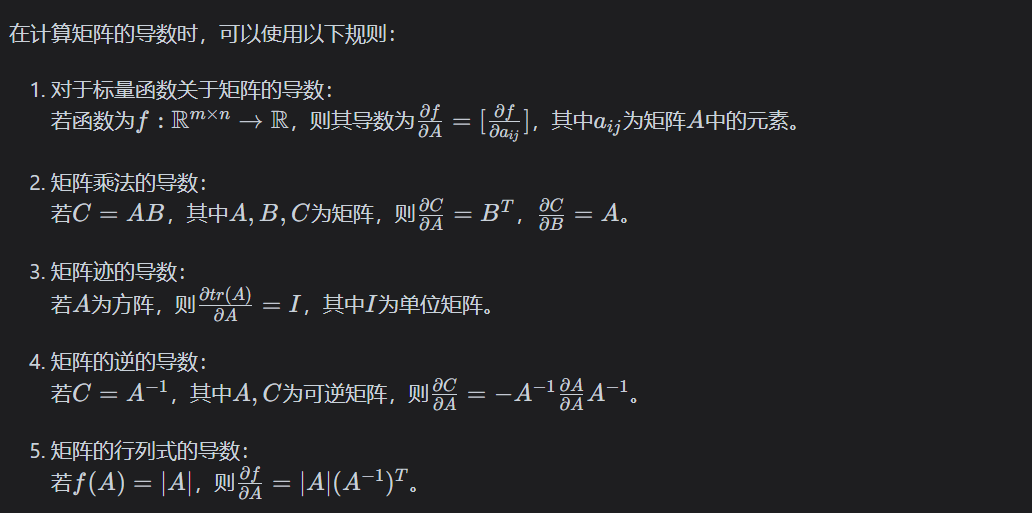

In [ ]:
hpreact.shape, bngain.shape, bnraw.shape,bnbias.shape

In [ ]:
bnraw.shape,bndiff.shape, bnvar_inv.shape

In [ ]:
#bnvar = 1 / (n-1)*bndiff2.sum(0, keepdim=True)
#a11 a12
#a12 a22
#--->
#b1,b2,where:
#b1 = 1/(n-1) * (a11 +a21)
#b2 = 1/(n-1) * (a12 +a22)

In [ ]:
#bndiff = hprebn - bnmeani
bndiff.shape,hprebn.shape,bnmeani.shape

In [ ]:
#forward pass hprebn = embcat @ W1 + b1
hprebn.shape,embcat.shape,W1.shape , b1.shape

In [ ]:
#embcat = emb.view(emb.shape[0],-1) 
embcat.shape, emb.shape

In [ ]:
#emb = C[Xb] 
emb.shape,C.shape,Xb.shape
#just to undo the indexing

In [ ]:
#Exercise one:
#backward through the whole thing manually
#loss = -1/2a - 1/2b
#dloss/da = -1/2
dlogprobs = torch.zeros_like(logprobs)  #初始化与logprobs相同的张量形状
dlogprobs[range(n),Yb] = -1.0/n
dprobs = (1.0/probs) * dlogprobs
#dcounts_sum_inv = counts * dprobs  这是错的
#因为probs = counts * counts_sum_inv计算时隐含broadcasting
dcounts_sum_inv = (counts * dprobs).sum(1,keepdim=True)
dcounts = counts_sum_inv * dprobs  #计算dcounts的第一部分
dcounts_sum = (-counts_sum**-2)*dcounts_sum_inv
dcounts += torch.ones_like(counts) *dcounts_sum  #计算dcounts的第二部分
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()  #计算dlogits的第一部分
dlogit_maxes = (-dnorm_logits).sum(1,keepdim=True)
dlogits +=F.one_hot(logits.max(1).indices,num_classes=logits.shape[1]) * dlogit_maxes
dh  = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) *dh
dbngain = (bnraw * dhpreact).sum(0,keepdim = True)
dbnraw = (bngain * dhpreact)
dbnbias = dhpreact.sum(0,keepdim = True)
dbndiff = bnvar_inv * dbnraw  #计算dbndiff的第一部分
dbnvar_inv = (bndiff * dbnraw).sum(0,keepdim=True)
dbnvar =( -0.5*(bnvar + 1e-5)**-1.5)*dbnvar_inv
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += (2 * bndiff)* dbndiff2 
dhprebn = dbndiff.clone()
dbnmeani = (-torch.ones_like(bndiff)* dbndiff).sum(0)
dhprebn += 1.0/n *torch.ones_like(hprebn) * dbnmeani
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
        
cmp('logprobs',dlogprobs, logprobs)
cmp('probs',dprobs, probs)
cmp('counts_sum_inv',dcounts_sum_inv,counts_sum_inv)
cmp('counts',dcounts, counts)
cmp('counts_sum',dcounts_sum, counts_sum)
cmp('norm_logits',dnorm_logits, norm_logits)
cmp('logits',dlogits, logits)
cmp('logit_maxes',dlogit_maxes, logit_maxes)
cmp('counts_sum',dcounts_sum, counts_sum)
cmp('h',dh, h)
cmp('W2',dW2,W2)
cmp('b2',db2,b2)
cmp('hpreact',dhpreact, hpreact)
cmp('bngain',dbngain, bngain)
cmp('bnraw',dbnraw, bnraw)
cmp('bndiff',dbndiff, bndiff)
cmp('bnvar_inv',dbnvar_inv, bnvar_inv)
cmp('bnvar',dbnvar, bnvar)
cmp('bndiff2',dbndiff2,bndiff2)
cmp('bnmeani',dbnmeani,bnmeani)
cmp('bndiff2',dbndiff2,bndiff2)
cmp('hprebn',dhprebn,hprebn)
cmp('embcat',dembcat,embcat)
cmp('W1',dW1,W1)
cmp('b1',db1,b1)
cmp('emb',demb,emb)
cmp('C',dC,C)

In [ ]:
# exercise two: back prop through cross_entropy but all in one go

#合并forward pass:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(),'diff:',(loss_fast-loss).item())

In [ ]:
dlogits = F.softmax(logits,1)
dlogits[range(n),Yb] -=1
dlogits/=n

cmp('logits',dlogits,logits)

In [ ]:
F.softmax(logits,1)[0]

In [ ]:
dlogits[0]*n

In [ ]:
dlogits[0].sum()

In [ ]:
plt.figure(figsize = (8,8))
plt.imshow(dlogits.detach(),cmap = 'grey')
#黑色的代表correct answer

logits:the probabilities that the properties Matrix in the forward pass

In [ ]:
#exercise three:
#back prop through batch norm but all in one go
#calculate dhprebn given dhpreact
dhprebn = bngain* bnvar_inv/n * (n*dhpreact - dhpreact.sum(0)-n(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('hprebn',dhprebn,hprebn)

In [ ]:
#Putting it all together
#train the MLP neural net with your own backward pass

#init
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(1337)
C = torch.randn((vocab_size,n_embd),generator = g)
#Layer 1
W1 = torch.randn((n_embd*block_size,n_hidden),generator = g)*(5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,generator = g) * 0.1
#Layer 2
W2 = torch.randn((n_hidden,vocab_size),generator = g) * 0.1
b2 = torch.randn(vocab_size, generator = g) * 0.1


